In [19]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [20]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [21]:
index_to_word = {index:word for word, index in word_to_index.items()}
print(index_to_word[7])

고


In [27]:
#실제 인코딩 인덱스는 제공된 word_to_index에서 index 기준으로 3씩 뒤로 밀려 있습니다.  
word_to_index = {k:(v+3) for k,v in word_to_index.items()}

# 처음 몇 개 인덱스는 사전에 정의되어 있습니다
word_to_index["<PAD>"] = 0
word_to_index["<굳>"] = 1
word_to_index["<떽>"] = 2  # unknown
word_to_index["<라>"] = 3

index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[1])     # '<BOS>' 가 출력됩니다. 
print(word_to_index['오늘'])  # 4 이 출력됩니다. 
print(index_to_word[2])     # 'the' 가 출력됩니다.

<굳>
496
<떽>


In [28]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [29]:

import numpy as np
import tensorflow as tf
import os

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)



(146182, 41)


In [9]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
# model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
# model.add(tf.keras.layers.MaxPooling1D(3))
model.add(tf.keras.layers.Conv1D(64, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(3))
model.add(tf.keras.layers.Conv1D(32, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 64)          7232      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 64)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          14368     
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 264       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9

In [42]:
# validation set 10000건 분리
x_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


# Y 의 형태는 x 의 쉐잎보다 차원이 낮다는 점을 명심한다 

In [31]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
2128/2128 [==============================] - 15s 6ms/step - loss: 0.5764 - accuracy: 0.6400 - val_loss: 0.3672 - val_accuracy: 0.8392
Epoch 2/20
2128/2128 [==============================] - 11s 5ms/step - loss: 0.3393 - accuracy: 0.8547 - val_loss: 0.3297 - val_accuracy: 0.8564
Epoch 3/20
2128/2128 [==============================] - 11s 5ms/step - loss: 0.3005 - accuracy: 0.8742 - val_loss: 0.3262 - val_accuracy: 0.8593
Epoch 4/20
2128/2128 [==============================] - 11s 5ms/step - loss: 0.2787 - accuracy: 0.8848 - val_loss: 0.3252 - val_accuracy: 0.8585
Epoch 5/20
2128/2128 [==============================] - 11s 5ms/step - loss: 0.2612 - accuracy: 0.8928 - val_loss: 0.3288 - val_accuracy: 0.8598
Epoch 6/20
2128/2128 [==============================] - 11s 5ms/step - loss: 0.2455 - accuracy: 0.8999 - val_loss: 0.3395 - val_accuracy: 0.8556
Epoch 7/20
2128/2128 [==============================] - 11s 5ms/step - loss: 0.2311 - accuracy: 0.9069 - val_loss: 0.3467 - val_ac

In [32]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.6590 - accuracy: 0.8284
[0.6590453386306763, 0.8283866047859192]


In [33]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


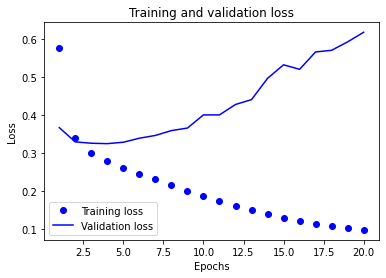

In [34]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss') #X 축 , y 축 으로 타이핑  
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

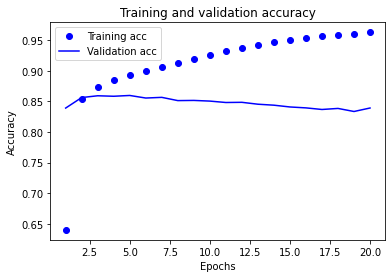

In [35]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [36]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 200)


In [37]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 



In [38]:
gensim.__version__
from gensim.models import KeyedVectors

In [49]:
from tensorflow.keras.initializers import Constant
# 임베딩 레이어 변경
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import gensim
import numpy as np
import keras
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec_path = os.getenv('HOME')+'/aiffel/ko.bin'

word2vec = gensim.models.Word2Vec.load(word2vec_path)
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

#embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩 차례대로 카피
for i in range(5,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]


word2vec.wv.most_similar("행복") 

# for i in range(4,vocab_size):
#     if index_to_word[i] in word2vec:
#         embedding_matrix[i] = word2vec[index_to_word[i]]

# word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_path, binary=False)
# vector = word_vectors['한']
# vector

KeyError: 5

(106182, 41)
(106182,)
(146182, 41)
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_8 (LSTM)                (None, 16)                13888     
_________________________________________________________________
dense_18 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 9         
Total params: 2,014,033
Trainable params: 2,014,033
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
36/36 [==============================] - 3s 33ms/step - loss: 0.6931 - accuracy: 0.5062 - val_loss: 0.6909 - val_accuracy: 0.5231
Epoch 2/15
36/36 [==============================] - 1s 22ms/step

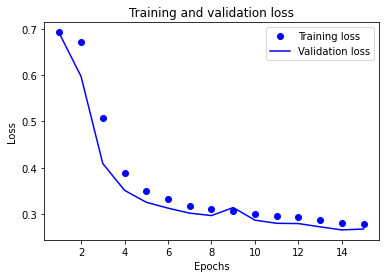

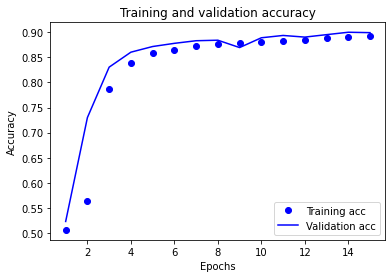

In [47]:
# 임베딩 레이어 변경
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                       value=word_to_index["<PAD>"],
                                                     padding='post', maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                       value=word_to_index["<PAD>"],
                                       padding='post',
                                       maxlen=maxlen)

x_val = X_train[:40000]
y_val = y_train[:40000]

#validation set을 제외한 나머지는 train set으로 사용
partial_x_train = X_train[40000:]
partial_y_train = y_train[40000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

print(X_train.shape)

# 모델 설계
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용!!!
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.LSTM(16))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

# 모델 학습
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=15

patial_x_train = np.asarray(partial_x_train)
patial_y_train = np.asarray(partial_y_train)



history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=4096,
                    validation_data=(x_val, y_val),
                    verbose=1)

# 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

# 모델의 fitting 과정 중의 정보들이 history 변수에 저장
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

# 도식화 Training and Validation loss
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Training and Validation accuracy
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# GlobalMaxPooling 1D 레이어만 사용한 모델(아래)


In [50]:
#어휘 사전의 크기(10,000개의 단어)
vocab_size = 10000    

#단어 하나를 표현하는 임베딩 벡터의 차원수(변경가능)
word_vector_dim = 16  

#GlobalMaxPooling1D레이어 하나만 사용한 모델
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  #최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [51]:
#GlobalMaxPooling1D레이어 하나만 사용한 모델 학습
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=5

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/5
208/208 [==============================] - 1s 4ms/step - loss: 0.6036 - accuracy: 0.7632 - val_loss: 0.4598 - val_accuracy: 0.8179
Epoch 2/5
208/208 [==============================] - 1s 4ms/step - loss: 0.3944 - accuracy: 0.8341 - val_loss: 0.3693 - val_accuracy: 0.8367
Epoch 3/5
208/208 [==============================] - 1s 4ms/step - loss: 0.3340 - accuracy: 0.8583 - val_loss: 0.3552 - val_accuracy: 0.8432
Epoch 4/5
208/208 [==============================] - 1s 4ms/step - loss: 0.3038 - accuracy: 0.8737 - val_loss: 0.3537 - val_accuracy: 0.8452
Epoch 5/5
208/208 [==============================] - 1s 4ms/step - loss: 0.2819 - accuracy: 0.8847 - val_loss: 0.3563 - val_accuracy: 0.8451


In [52]:
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 2s - loss: 0.3650 - accuracy: 0.8425
[0.365008682012558, 0.8424639701843262]


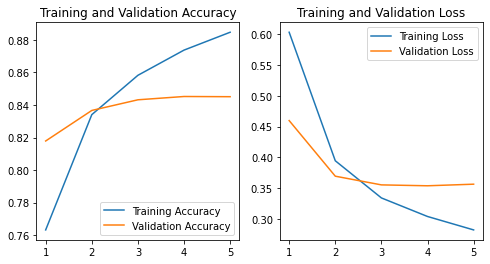

In [53]:
#Loss, Accuracy 그래프 시각화

history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Accuracy 그래프
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


### validation loss의 그래프가 train loss와의 이격이 발생하게 되면 더이상의 트레이닝은 무의미해진다

# 밑은 활성화함수 GELU 를 이용한 모델


In [54]:
#어휘 사전의 크기(10,000개의 단어)
vocab_size = 10000    

#단어 하나를 표현하는 임베딩 벡터의 차원수(변경가능)
word_vector_dim = 16  

#GlobalMaxPooling1D레이어 하나만 사용한 모델
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='ELU'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  #최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [55]:
#GlobalMaxPooling1D레이어 하나만 사용한 모델 학습
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=5

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/5
208/208 [==============================] - 1s 4ms/step - loss: 0.5754 - accuracy: 0.7617 - val_loss: 0.4239 - val_accuracy: 0.8172
Epoch 2/5
208/208 [==============================] - 1s 4ms/step - loss: 0.3782 - accuracy: 0.8368 - val_loss: 0.3658 - val_accuracy: 0.8372
Epoch 3/5
208/208 [==============================] - 1s 4ms/step - loss: 0.3289 - accuracy: 0.8613 - val_loss: 0.3547 - val_accuracy: 0.8439
Epoch 4/5
208/208 [==============================] - 1s 4ms/step - loss: 0.3001 - accuracy: 0.8755 - val_loss: 0.3541 - val_accuracy: 0.8454
Epoch 5/5
208/208 [==============================] - 1s 4ms/step - loss: 0.2783 - accuracy: 0.8854 - val_loss: 0.3583 - val_accuracy: 0.8454


In [56]:
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 2s - loss: 0.3678 - accuracy: 0.8411
[0.36782917380332947, 0.8411213159561157]


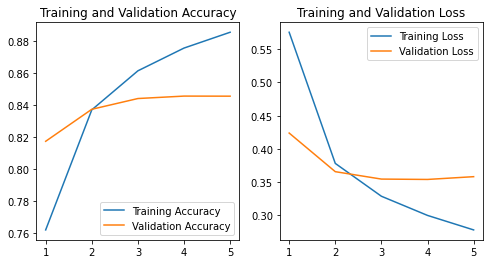

In [57]:
#Loss, Accuracy 그래프 시각화

history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Accuracy 그래프
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [59]:
#어휘 사전의 크기(10,000개의 단어)
vocab_size = 10000    

#단어 하나를 표현하는 임베딩 벡터의 차원수(변경가능)
word_vector_dim = 16  

#GlobalMaxPooling1D레이어 하나만 사용한 모델
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='ELU'))

model.add(keras.layers.Dense(8, activation='ELU'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  #최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 16)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_26 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 9         
Total params: 160,217
Trainable params: 160,217
Non-trainable params: 0
_________________________________________________________________


In [60]:
#GlobalMaxPooling1D레이어 하나만 사용한 모델 학습
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=5

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/5
208/208 [==============================] - 1s 4ms/step - loss: 0.5476 - accuracy: 0.7435 - val_loss: 0.3937 - val_accuracy: 0.8239
Epoch 2/5
208/208 [==============================] - 1s 4ms/step - loss: 0.3561 - accuracy: 0.8453 - val_loss: 0.3581 - val_accuracy: 0.8401
Epoch 3/5
208/208 [==============================] - 1s 4ms/step - loss: 0.3127 - accuracy: 0.8689 - val_loss: 0.3545 - val_accuracy: 0.8435
Epoch 4/5
208/208 [==============================] - 1s 4ms/step - loss: 0.2852 - accuracy: 0.8827 - val_loss: 0.3608 - val_accuracy: 0.8447
Epoch 5/5
208/208 [==============================] - 1s 4ms/step - loss: 0.2645 - accuracy: 0.8931 - val_loss: 0.3702 - val_accuracy: 0.8446


In [61]:
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 2s - loss: 0.3804 - accuracy: 0.8405
[0.3803829550743103, 0.8404906988143921]


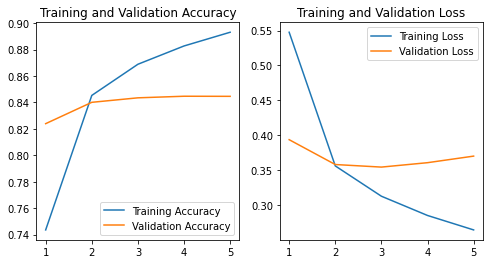

In [62]:
#Loss, Accuracy 그래프 시각화

history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Accuracy 그래프
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()